# What I want to do

Each section of this notbook is about a different part on GANs

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time

from google.colab import drive

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
batch_size = 256

all_images = tf.concat([x_train, x_test], axis=0)
all_images = tf.reshape(all_images, (-1, 28, 28, 1))
all_images = tf.cast(all_images, tf.float32)
all_images = (all_images - 127.5) / 127.5
dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(buffer_size=60000).batch(batch_size)


In [4]:
def Discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (3,3), padding='same', input_shape=(28,28,1)))
  model.add(layers.LeakyReLU(alpha=0.2))

  # downsample
  model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))

  # downsample
  model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))

  # downsample
  model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))

  # classifier
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation='sigmoid'))

  return model



def Generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 28, 28, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (3, 3), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

def generate_random_points(latent_dim, n_samples):
  x_input = tf.random.normal([n_samples, latent_dim])
  return x_input



tf.Tensor([[0.49981683]], shape=(1, 1), dtype=float32)


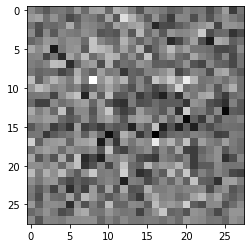

In [5]:
generator = Generator()
discriminator = Discriminator()
fake_image = generator(generate_random_points(100, 1), training=False)
print(discriminator(fake_image, training = False))
plt.imshow(fake_image[-1,:,:,0], cmap='gray')

In [6]:
generator_optimizer = tf.keras.optimizers.Adam(.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(.0001)

cross_entorpy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_image, fake_image):
  real_loss = cross_entorpy(tf.ones_like(real_image), real_image)
  fake_loss = cross_entorpy(tf.zeros_like(fake_image), fake_image)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_image):
  return cross_entorpy(tf.ones_like(fake_image), fake_image)

In [7]:
@tf.function
def train_step(real_images):
  random_sample_points = generate_random_points(latent_dim=100, n_samples=batch_size)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(random_sample_points, training=True)

    real_output = discriminator(real_images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [8]:
def train(epochs = 5):
  test_latent_vectors = generate_random_points(100, 8)

  for epoch in range(epochs):
    start = time.time()
    print("\nStart epoch {}/{} --- ".format(epoch+1, epochs), end="")

    for real_images in dataset:
      gen_loss, disc_loss = train_step(real_images)

    
    print("discriminator loss %.2f -----" % (disc_loss), end="")
    print("generator loss %.2f  ****** " % (gen_loss), end="")
    print("Time taken: ", time.time()-start)

    generate_and_save_images(generator, test_latent_vectors)



def generate_and_save_images(model, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(16,16))
  for i in range(predictions.shape[0]):
      plt.subplot(1, 8, i+1)
      plt.imshow(predictions[i,:,:,0], cmap='gray')
      plt.axis('off')
  plt.show()


Start epoch 1/50 --- discriminator loss 1.11 -----generator loss 0.66  ****** Time taken:  34.02756595611572


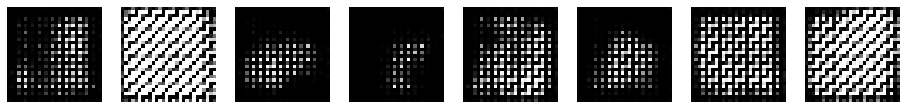


Start epoch 2/50 --- discriminator loss 1.12 -----generator loss 0.68  ****** Time taken:  33.04255962371826


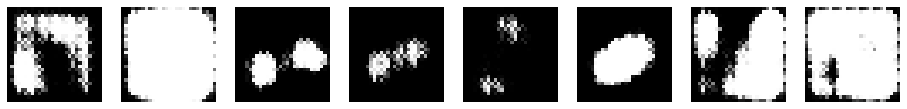


Start epoch 3/50 --- discriminator loss 1.39 -----generator loss 0.69  ****** Time taken:  32.69777536392212


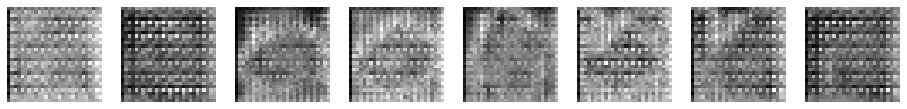


Start epoch 4/50 --- discriminator loss 1.39 -----generator loss 0.69  ****** Time taken:  32.402342796325684


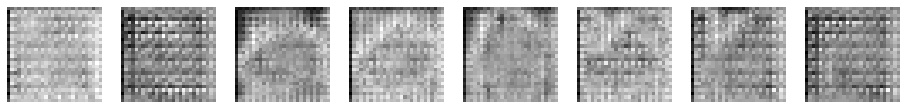


Start epoch 5/50 --- discriminator loss 1.39 -----generator loss 0.69  ****** Time taken:  32.72959327697754


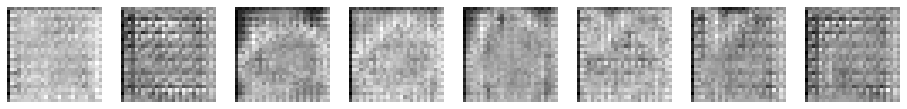


Start epoch 6/50 --- discriminator loss 1.39 -----generator loss 0.69  ****** Time taken:  32.525197982788086


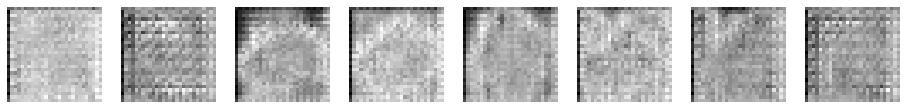


Start epoch 7/50 --- discriminator loss 1.39 -----generator loss 0.69  ****** Time taken:  32.562880992889404


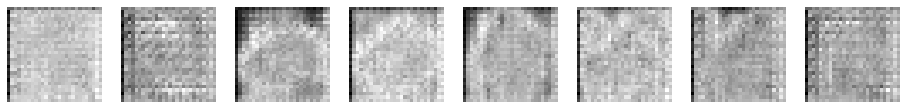


Start epoch 8/50 --- 

KeyboardInterrupt: ignored

In [ ]:
train(50)

In [ ]:
fake_image = generator(generate_random_points(100, 1), training=False)
print(discriminator(fake_image, training=False))
plt.imshow(fake_image[-1,:,:,0], cmap='gray')


In [ ]:
plt.imshow(all_images[5, :, :, 0])